# CSE527 Homework 5
**Due date: 23:59 on Nov 24, 2020 (Tuesday)**

---
In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

## Enable Colab GPU Acceleration
---
Navigation menu: **Runtime->Change runtime type->Hardware accelerator->GPU**

## Local Machine Prerequisites
---
Since we are using Google Colab, all the code is run on the server environment where lots of libraries or packages have already been installed. In case of missing 
 libraries or if you want to install them in your local machine, below are the links for installation.
* **Install Python 3.6.9**: https://www.python.org/downloads/ or use Anaconda (a Python distribution) at https://docs.continuum.io/anaconda/install/. Below are some materials and tutorials which you may find useful for learning Python if you are new to Python.
  - https://docs.python.org/3.6/tutorial/index.html
  - https://www.learnpython.org/
  - https://docs.opencv.org/4.1.2/d6/d00/tutorial_py_root.html
  - http://www.scipy-lectures.org/advanced/image_processing/index.html


* **Install Python packages**: install Python packages: `numpy`, `matplotlib`, `opencv-python` using pip, for example:
```
pip install numpy matplotlib opencv-python
``` 
	Note that when using “pip install”, make sure that the version you are using is python3. Below are some commands to check which python version it uses in you machine. You can pick one to execute:
  
```
    pip show pip
    pip --version
    pip -V
```

In case of the wrong version, use `pip3` for python3 explictly.

* **Install Jupyter Notebook**: follow the instructions at http://jupyter.org/install.html to install Jupyter Notebook and familiarize yourself  with it. *After you have installed Python and Jupyter Notebook, please open this notebook file with your Jupyter Notebook and do your homework there.*


## Description
---
In this homework, we will implement an image-to-image translation method, based on
[pix2pix](https://phillipi.github.io/pix2pix/). To be more specific,  we'll built from scratch a GAN which can translate abstract labels into facade images. 

Before we start, please read the [pix2pix paper](https://arxiv.org/pdf/1611.07004.pdf) first and understand how pix2pix works.

There are 6 parts + 1 bonus part in this homework with a total of 110 points including 10 bonus points. Be sure to read **Submission Guidelines** below. They are important.

**Do not upload** the data subfolder or trained models before submitting on blackboard due to the size limit.


## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.

In [ ]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Replace -----/-----/-----/' with the path such that "CSE527-HW5-fall20" is your working directory
%cd '/content/gdrive/MyDrive/CV/Kandari_Srinivas_112713946_HW5'

/content/gdrive/MyDrive/CV/Kandari_Srinivas_112713946_HW5




```
# This is formatted as code
```

### Part 1 Load dataset
---

We'll train a model to generate pictures of facades from label maps, using the [CMP Facade
Database](http://cmp.felk.cvut.cz/~tylecr1/facade/) . This dataset contains 606 rectified images of facades from various sources, which have been manually annotated.

**{10 points}** For the training process, we will use a batch size equal to `1`, as in the original paper. During testing, we will process `4` images in a single batch, so that we can visualize
several results at once.

Load the training set and test set under the folder `./facades`. Normalize the images to $[-1, 1]$. For each set, return a batch list. Show one image from the training set and its label side by side in a `1x2` grid.

In [ ]:
# download the dataset
! chmod +x ./download_dataset.sh
! ./download_dataset.sh

for details.

--2020-11-24 20:49:26--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.189.73
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.189.73|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M  1.00MB/s    in 24s     

2020-11-24 20:49:50 (1.20 MB/s) - ‘facades.tar.gz’ saved [30168306/30168306]

facades/
facades/test/
facades/test/27.jpg
facades/test/5.jpg
facades/test/72.jpg
facades/test/1.jpg
facades/test/10.jpg
facades/test/100.jpg
facades/test/101.jpg
facades/test/102.jpg
facades/test/103.jpg
facades/test/104.jpg
facades/test/105.jpg
facades/test/106.jpg
facades/test/11.jpg
facades/test/12.jpg
facades/test/13.jpg
facades/test/14.jpg
facades/test/15.jpg
facades/test/16.jpg
facades/test/17.jpg
facades/test/18.jp

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
Variable = torch.autograd.Variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

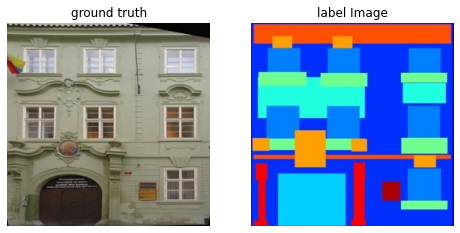

In [ ]:
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
  

def img_norm(img):
    img_out = img.astype(np.float)
    # normalize img pixels to [-1, 1]
    ##########--WRITE YOUR CODE HERE--##########
    img_out = (img_out - 127.5) / 127.5       #127.5
    ##########-------END OF CODE-------##########
    return img_out
  

def load_dataset(path, shuffle=False):
    # load the images under the folder
    # remember to normalize them to [-1, 1]
    image_names = [name for name in glob.glob(path + '/*.jpg')]
    data = []
    ##########--WRITE YOUR CODE HERE--##########
    for name in image_names:
      img = cv2.imread(name)
      real = img[:, :256, :]
      facade = img[:, 256:, :]
      real = torch.from_numpy(np.transpose(img_norm(real), [2, 0, 1]))
      facade = torch.from_numpy(np.transpose(img_norm(facade), [2, 0, 1]))
      data.append((real, facade))
    ##########-------END OF CODE-------##########
    # return a list of tuples.
    # for each tuple, the first element is ground truth, the second one is label image
    # both images should be tensors
    return data


set_seeds(302)
train = load_dataset('./facades/train', shuffle=True)
test = load_dataset('./facades/test')


def show_img_pair(s_left, s_right):
    # convert the pixels back to [0, 1] when visualizing
    
    ##########--WRITE YOUR CODE HERE--##########

    s_left = np.transpose(s_left.numpy(), [1,2,0]) * 0.5 + 0.5
    s_right = np.transpose(s_right.numpy(), [1,2,0]) * 0.5 + 0.5
    s_left = cv2.cvtColor(np.float32(s_left), cv2.COLOR_BGR2RGB)
    s_right = cv2.cvtColor(np.float32(s_right), cv2.COLOR_BGR2RGB)
    fig, axs = plt.subplots(1, 2 , figsize=(8,4))
    axs[0].imshow(s_left)
    axs[0].axis('off')
    axs[0].set_title("ground truth")

    axs[1].imshow(s_right)
    axs[1].axis('off')
    axs[1].set_title("label Image")
    ##########-------END OF CODE-------##########    
    
    
idx = 150
show_img_pair(train[idx][0], train[idx][1])

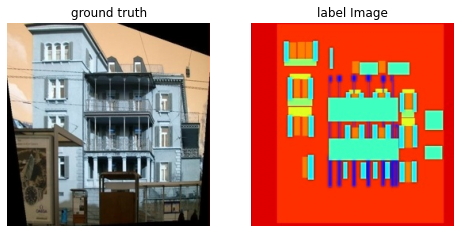

Text(0.5, 1.0, 'label Image')

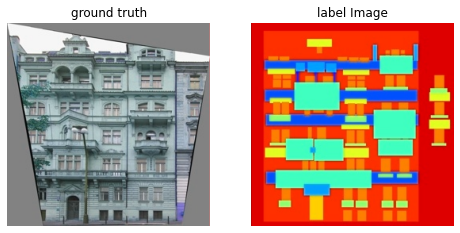

In [ ]:
img = cv2.imread("/content/gdrive/MyDrive/CV/Kandari_Srinivas_112713946_HW5/facades/train/100.jpg")
# temp = torch.from_numpy(img[:, 256:, :])
r = img[:, 256:, :]
l = img[:, :256, :]
# plt.imshow(r)
fig, axs = plt.subplots(1, 2 , figsize=(8,4))
axs[0].imshow(l)
axs[0].axis('off')
axs[0].set_title("ground truth")

axs[1].imshow(r)
axs[1].axis('off')
axs[1].set_title("label Image")
# # type(temp)

### Part 2 Models
---
In this part, we will define the network based on the architectures from the paper.
Please check the Appendix of the paper for the details of this architecture.

Let $Ck$ denote a Convolution-BatchNorm-ReLU layer with k filters. $CDk$
denotes a Convolution-BatchNormDropout-ReLU layer with a dropout rate of 50%. All
convolutions are 4 x 4 spatial filters applied with stride 2. Convolutions in the encoder,
and in the discriminator, downsample the input by a factor of 2, whereas in the decoder
they upsample the input by a factor of 2.

#### **{15 points}** (a) Generator
The U-Net encoder-decoder architecture consists of:

U-Net encoder:
$$C64-C128-C256-C512-C512-C512-C512-C512$$

U-Net decoder:

$$CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128$$

After the last layer in the decoder, a convolution is applied to map to the number
of output channels, which is `3` in our problem, followed by a `tanh` function. As a
special case, batch normalization is not applied to the first $C64$ layer in the encoder.
All ReLUs in the encoder are leaky, with slope `0.2`, while ReLUs in the decoder are
not leaky.
If you are not familiar with the architecture of UNet, please check [this paper](https://arxiv.org/abs/1505.04597) first.

#### **{15 points}** (b) Discriminator

The discriminator architecture is:
$$C64-C128-C256-C512$$
After the last layer, a convolution is applied to map to a 1-dimensional output,
followed by a sigmoid function. As an exception to the above notation, batch
normalization is not applied to the first $C64$ layer. All ReLUs are leaky, with slope
`0.2`.

Hint: Use `torch.nn.functional.leaky_relu` for leaky ReLU.

In [ ]:
# discriminator
class Discriminator(nn.Module):
    def __init__(self, n_channels):
        # n_channels means num of input channels
        super(Discriminator, self).__init__()
        ##########--WRITE YOUR CODE HERE--##########
        # C64−C128−C256−C512
        def block(in_chann, out_chann, strides=2, batchNorm =True):
          # Convolution-BatchNorm-LeakyReLU
          seq = [nn.Conv2d(in_chann, out_chann, 4, strides, 1)]  
          if(batchNorm):
            seq.append(nn.BatchNorm2d(out_chann))  # outsize ???
          seq.append(nn.LeakyReLU(0.2))
          return seq
        # C64−C128−C256−C512

        self.disc1 = nn.Sequential(*block(n_channels, 64, batchNorm=False))
        self.disc2 = nn.Sequential(*block(64, 128))
        self.disc3 = nn.Sequential(*block(128, 256))
        self.disc4 = nn.Sequential(*block(256, 512, strides=1))
        self.disc5 = nn.Sequential(*block(512, 1, strides=1, batchNorm=False), nn.Sigmoid())

        ##########-------END OF CODE-------##########
        
    def forward(self, x):
        ##########--WRITE YOUR CODE HERE--##########
        x = self.disc1(x)
        x = self.disc2(x)
        x = self.disc3(x)
        x = self.disc4(x)
        x_d = self.disc5(x)
        ##########-------END OF CODE-------##########
        return x_d

##########--WRITE YOUR CODE HERE--##########    
netD = Discriminator(6)
# feel free to do some sanity check here

##########-------END OF CODE-------##########    

In [ ]:
netD

Discriminator(
  (disc1): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (disc2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (disc3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (disc4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (disc5): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): S

In [ ]:
class GeneratorUNet(nn.Module):
    def __init__(self, n_channels):
        super(GeneratorUNet, self).__init__()

        ##########--WRITE YOUR CODE HERE--##########
        def block(in_chann, out_chann, dropout=False, batchNorm =True, isLeaky= False, isEncoder= True):
          # Convolution-BatchNorm-ReLU
          # C64−C128−C256−C512−C512−C512−C512−C512
          if(isEncoder):
            seq = [nn.Conv2d(in_chann, out_chann, 4, 2,1)] 
          else:
            seq = [nn.ConvTranspose2d(in_chann, out_chann,4,2,1)] 
          if(batchNorm):
            seq.append(nn.BatchNorm2d(out_chann))  # outsize ???
          if(dropout):
            seq.append(nn.Dropout2d())
          if(isLeaky):
            seq.append(nn.LeakyReLU(0.2))
          else:
            seq.append(nn.ReLU())
          return seq

        ###### ENCODER ##########
        # C64−C128−C256−C512−C512−C512−C512−C512
        self.encoder1 = nn.Sequential(*block(3, 64, batchNorm=False, isLeaky = True))
        self.encoder2 = nn.Sequential(*block(64, 128, isLeaky = True))
        self.encoder3 = nn.Sequential(*block(128, 256, isLeaky = True))
        self.encoder4 = nn.Sequential(*block(256, 512, isLeaky = True))
        self.encoder5 = nn.Sequential(*block(512, 512, isLeaky = True))
        self.encoder6 = nn.Sequential(*block(512, 512, isLeaky = True))
        self.encoder7 = nn.Sequential(*block(512, 512, isLeaky = True))
        self.encoder8 = nn.Sequential(*block(512, 512, isLeaky = True, batchNorm=False))

        ###### DECODER ##########
        # CD512−CD1024−CD1024−C1024−C1024−C512−C256−C128
        self.decoder1 =  nn.Sequential(*block(512, 512, dropout = True, isEncoder=False))
        self.decoder2 =  nn.Sequential(*block(512 * 2, 512, dropout = True, isEncoder=False))
        self.decoder3 =  nn.Sequential(*block(512 * 2, 512, dropout = True, isEncoder=False))
        self.decoder4 =  nn.Sequential(*block(512 * 2, 512, isEncoder=False))
        self.decoder5 =  nn.Sequential(*block(512 * 2, 256, isEncoder=False))
        self.decoder6 =  nn.Sequential(*block(256 * 2, 128, isEncoder=False))
        self.decoder7 =  nn.Sequential(*block(128 * 2, 64, isEncoder=False))
        self.decoder8 =  nn.Sequential(nn.ConvTranspose2d(128, 3, 4, 2, 1), nn.Tanh())

        
        
        ##########-------END OF CODE-------##########
    
    def forward(self, x):   
        ##########--WRITE YOUR CODE HERE--##########
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4)
        e6 = self.encoder6(e5)
        e7 = self.encoder7(e6)
        e8 = self.encoder8(e7)

        d1 = self.decoder1(e8)
        d1 = torch.cat((d1 , e7), 1)
        d2 = self.decoder2(d1)
        d2 = torch.cat((d2 , e6), 1)
        d3 = self.decoder3(d2)
        d3 = torch.cat((d3 , e5), 1)
        d4 = self.decoder4(d3)
        d4 = torch.cat((d4 , e4), 1)
        d5 = self.decoder5(d4)
        d5 = torch.cat((d5 , e3), 1)
        d6 = self.decoder6(d5)
        d6 = torch.cat((d6 , e2), 1)
        d7 = self.decoder7(d6)
        d7 = torch.cat((d7 , e1), 1)
        d8 = self.decoder8(d7)
        

        x_g = d8
        ##########-------END OF CODE-------##########
        return x_g


##########--WRITE YOUR CODE HERE--##########    
netG = GeneratorUNet(3)
netGL1 = GeneratorUNet(3)
# feel free to do some sanity check here

##########-------END OF CODE-------##########  

In [ ]:
netG

GeneratorUNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (encoder4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (encoder5): Sequential(
    (0): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e

### Part 3 Optimizor
---
**{5 points}** For optimization, we'll use the Adam optimizer, with a learning rate of `0.0002`, and momentum parameters  $\beta_1= 0.5$; $\beta_2 = 0.999$.

In [ ]:
# Define the optimizors here, make sure you give them the right parameters

##########--WRITE YOUR CODE HERE--########## 
optimizer_G = optim.Adam(netG.parameters(), 0.0002, betas=(0.5, 0.999))
optimizer_GL1 = optim.Adam(netGL1.parameters(), 0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(netD.parameters(), 0.0002, betas=(0.5, 0.999))

##########-------END OF CODE-------##########

### Part 4 Training
---
**{20 points}** For each batch, first train discriminator D by using the average loss of real image and fake image. Then train generator G by using the following loss equation.
$$G^*=\arg \min_{G} \max_{D} L_{cGAN}(G, D) + \lambda L_{L1}(G) $$

In this homework, you will train two different models: one using only the L1 loss, the other using the equation above with $\lambda = 100$. 

As a sanity check, please compare your results with those in the paper (e.g. Figure 4) to make sure they roughly match.

Train the network for at least 20 epochs (at least 10 epochs for the model with only L1 loss,) but you are encouraged to train longer to obtain better results. (In the paper, they train
for 200 epochs.) Save your models to `pix2pix.pth` and `pix2pixL1.pth` using the given code. 

Note: Training training each epoch should take less than 2 minutes if you are using Colab. **Remember to save your models regularly** so you won't lose your progress accidentally.

**{5 points}** In the end, plot the Generator/Discriminator (G/D) loss history (averaged per epoch) of the two models with respect to the epoch in two plots. i.e. the first plot should contain the G/D loss of the model with L1 and cGAN, the second plot should contain the L1 loss of the other model.


In [ ]:
torch.cuda.is_available()
# CUDA_LAUNCH_BLOCKING =1

True

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

netG = netG.to(device)
netD = netD.to(device)
netG.train()
netD.train()
netGL1 = netGL1.to(device)
netGL1.train()
##########--WRITE YOUR CODE HERE--########## 
loss_iter = [[], [], []]
G_losses = loss_iter[0]
GL1_losses = loss_iter[1]
D_losses = loss_iter[2]
batch_size = 1
batches = 1000
epochs = 70
for epoch in range(epochs):
  ## training both G and GL1 in same for loop
  torch.save({
    'G': netG.state_dict(),
    'D': netD.state_dict(),
    'epoch': epoch,
    'loss': loss_iter,
    }, 'pix2pix.pth')
  torch.save({
    'G': netGL1.state_dict(),
    'epoch': 70,
    'loss': loss_iter,
    }, 'pix2pixL1.pth')
  count = 0
  for real_image, context in train:
    print("COunt: ", count)
    count+=1
    netD.train()
    netG.eval()
    netD.zero_grad()
    netG.zero_grad()
    real_images = real_image.unsqueeze(0).float().cuda()
    contexts = context.unsqueeze(0).float().cuda()
    fake_images = netG(contexts)
    
    Disc_real = torch.cat((contexts, real_images), 1)
    Disc_fake = torch.cat((contexts, fake_images.detach()), 1)
    real_validity = netD(Disc_real)
    fake_validity = netD(Disc_fake)
    if cuda:
      BCE_loss = nn.BCELoss().cuda()
      L1_loss = nn.L1Loss().cuda()
      D_loss = BCE_loss(real_validity, Variable(torch.ones(real_validity.size()).cuda())) + BCE_loss(fake_validity, Variable(torch.zeros(fake_validity.size()).cuda())) 

    else:
      BCE_loss = nn.BCELoss()
      L1_loss = nn.L1Loss()
      D_loss = BCE_loss(real_validity, Variable(torch.ones(real_validity.size()))) + BCE_loss(fake_validity, Variable(torch.zeros(fake_validity.size()))) 
    D_loss.backward()
    optimizer_D.step()
    D_losses.append(D_loss.item())
    ####### GENERATOR ########
    netG.zero_grad()
    netD.eval()
    netG.train()
    # fake_images = netG(contexts)
    Disc_fake = torch.cat((contexts, fake_images), 1)
    fake_validity = netD(Disc_fake)
    if cuda:
      G_loss = BCE_loss(fake_validity, Variable(torch.ones(fake_validity.size()).cuda())) + 100 * L1_loss(fake_images, real_images)
    else:
      G_loss = BCE_loss(fake_validity, Variable(torch.ones(fake_validity.size()))) + 100 * L1_loss(fake_images, real_images)
    
    G_loss.backward()
    optimizer_G.step()
    G_losses.append(G_loss.item())

    ####### GENERATOR L1 ########
    netGL1.zero_grad()
    fake_images = netGL1(contexts)
    if cuda:
      GL1_loss = L1_loss(fake_images, real_images)
    else:
      GL1_loss = L1_loss(fake_images, real_images)
    
    GL1_loss.backward()
    optimizer_GL1.step()
    GL1_losses.append(GL1_loss.item())

  print("Epoch: ", epoch, " Disc Loss: ", D_losses[-1], " Generator Loss: ", G_losses[-1], " Generator L1 Loss: ", GL1_losses[-1])




  ##########-------END OF CODE-------##########

In [ ]:
# codes for restoring models, feel free to change them

path = "pix2pix.pth"
checkpoint = torch.load(path)
netG.load_state_dict(checkpoint['G'])
netD.load_state_dict(checkpoint['D'])
epoch = checkpoint['epoch']
loss_iter = checkpoint['loss']

path = "pix2pixL1.pth"
checkpoint = torch.load(path)
netGL1.load_state_dict(checkpoint['G'])
epoch_l1 = checkpoint['epoch']
loss_iter_l1 = checkpoint['loss']

netD.to(device).eval()
netG.to(device).eval()
netGL1.to(device).eval()

GeneratorUNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (encoder4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (encoder5): Sequential(
    (0): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e

In [ ]:

def show_img_pair(s_left, s_right):
    # convert the pixels back to [0, 1] when visualizing
    
    ##########--WRITE YOUR CODE HERE--##########

    s_left = np.transpose(s_left, [1,2,0]) * 0.5 + 0.5
    s_right = np.transpose(s_right, [1,2,0]) * 0.5 + 0.5
    s_left = cv2.cvtColor(np.float32(s_left), cv2.COLOR_BGR2RGB)
    s_right = cv2.cvtColor(np.float32(s_right), cv2.COLOR_BGR2RGB)
    fig, axs = plt.subplots(1, 2 , figsize=(8,4))
    axs[0].imshow(s_left)
    axs[0].axis('off')
    axs[0].set_title("ground truth")

    axs[1].imshow(s_right)
    axs[1].axis('off')
    axs[1].set_title("label Image")
    ##########-------END OF CODE-------##########    

In [ ]:
device

device(type='cuda')

torch.Size([1, 3, 256, 256])
torch.float64


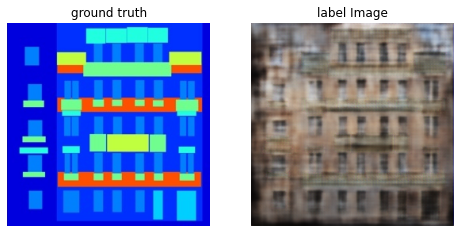

In [ ]:
torch.cuda.is_available()
CUDA_LAUNCH_BLOCKING =1

print(train[10][0].unsqueeze(0).shape)
print(train[10][0].dtype)
k = train[10][0].unsqueeze(0).to(device)


# show_img_pair(train[10][0],train[10][1]) # netD(train[10][0].unsqueeze(0)))
# # input = torch.cat(train[10][1], )
gen_image = netGL1(test[51][1].unsqueeze(0).float().cuda()).cpu().detach().squeeze()
show_img_pair(test[51][1], gen_image)
# gen_image.squeeze().shape

In [ ]:
netGL1 = netGL1.to(device)
netGL1.train()

##########--WRITE YOUR CODE HERE--########## 


##########-------END OF CODE-------##########

GeneratorUNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (encoder2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (encoder3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (encoder4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (encoder5): Sequential(
    (0): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e

In [ ]:
# # codes for saving models, feel free to change them

# torch.save({
#     'G': netG.state_dict(),
#     'D': netD.state_dict(),
#     'epoch': epoch,
#     'loss': loss_iter,
#     }, 'pix2pix.pth')

# torch.save({
#     'G': netGL1.state_dict(),
#     'epoch': epoch_l1,
#     'loss': loss_iter_l1,
#     }, 'pix2pixL1.pth')


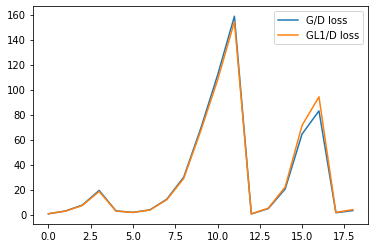

In [ ]:
# Plot the loss

##########--WRITE YOUR CODE HERE--##########
# len(G_losses)
G_losses = []
GL1_losses = []
D_losses = []
G_loss = 0 
GL1_loss = 0 
D_loss = 0
for i in range(0, 8000):
  if(i% 400 == 0 and i!=0):
    G_losses.append((G_loss) / D_loss)
    GL1_losses.append(GL1_loss / D_loss)
    # D_losses.append(D_loss /400)
    G_loss = 0 
    GL1_loss = 0 
    D_loss = 0
  G_loss += loss_iter[0][i] / 100
  GL1_loss += loss_iter[1][i]
  D_loss += loss_iter[2][i]
plt.plot(list(range(19)), G_losses, label= "G/D loss")
plt.plot(list(range(19)), GL1_losses, label="GL1/D loss")
# plt.plot(list(range(19)),D_losses, label="D loss")
# G_losses
plt.legend(loc="upper right")
##########-------END OF CODE-------##########

### Part 5 Evaluation
---

Compared to a classification problem, evaluating an image translation model could be tricky because we don't always have the ground-truth available. There are several different ways to compare the performance of different GAN models:

1. Visualize the generated images of different GAN models. 

2. Compute a distance, such as **Frechet Inception Distance** (**FID**, the smaller the better, [paper](https://arxiv.org/abs/1706.08500)), between the generated images and the real images, or compute the Inception Score (**IS**, the higher the better, [paper](https://arxiv.org/pdf/1606.03498.pdf)) for the generated images. We strongly encourage you to read these papers.

3. Using generated images for downstream tasks, such as classification, segmentation, etc. and computing the task accuracy.

Now it's your turn to evaluate the models you trained. 

**{5 points}** We'll first visualize `4` test samples and plot them as in Figure 4 in the pix2pix paper, to get some qualitative results. You can select any interesting samples from the **test set**.

**{5 points}** Then let's do some quantitative analysis. Adapt this **Inception Score** ([ref](https://github.com/sbarratt/inception-score-pytorch/blob/master/inception_score.py)) implementation, and report the mean score of each model on the test set. Again, you are encouraged to train your models longer.

Text(0.5, 1.0, 'L1')

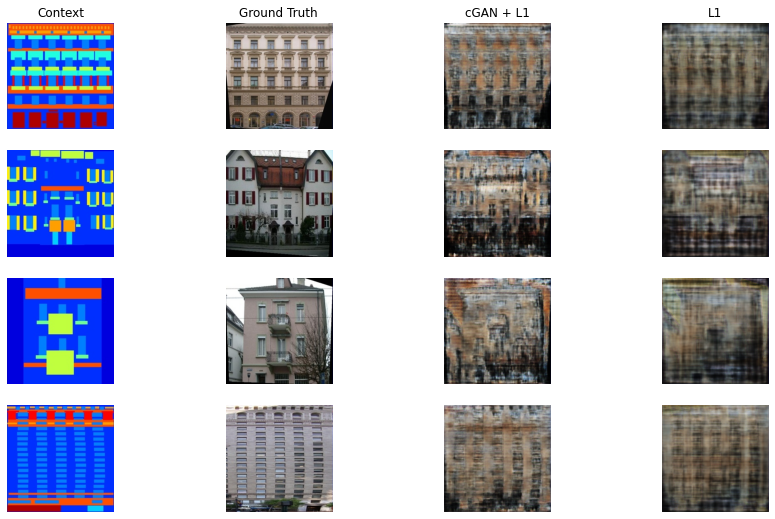

In [ ]:
# Visualization
# Please read Figure 4 in the pix2pix paper first
##########--WRITE YOUR CODE HERE--##########
netG.to(device).eval()
netGL1.to(device).eval()
real_images=torch.stack((test[8][0], test[20][0], test[32][0], test[39][0])).float().cuda()
contexts = torch.stack((test[8][1], test[20][1], test[32][1], test[39][1])).float().cuda()
gen_gs = netG(real_images)
gen_gl1s = netGL1(real_images)

fig, axs = plt.subplots(4, 4, figsize=(15,9))
for i in range(len(real_images)):
  real = cv2.cvtColor(np.float32(np.transpose(real_images[i].cpu().detach().numpy(), [1,2,0]) * 0.5 + 0.5), cv2.COLOR_BGR2RGB)
  context = cv2.cvtColor(np.float32(np.transpose(contexts[i].cpu().detach().numpy(), [1,2,0]) * 0.5 + 0.5), cv2.COLOR_BGR2RGB)
  gen_g = cv2.cvtColor(np.float32(np.transpose(gen_gs[i].cpu().detach().numpy(), [1,2,0]) * 0.5 + 0.5), cv2.COLOR_BGR2RGB)
  gen_gl1 = cv2.cvtColor(np.float32(np.transpose(gen_gl1s[i].cpu().detach().numpy(), [1,2,0]) * 0.5 + 0.5), cv2.COLOR_BGR2RGB)
  axs[i, 0].imshow(context)
  axs[i, 0].axis('off')
  axs[i, 1].imshow(real)
  axs[i, 1].axis('off')
  axs[i, 2].imshow(gen_g)
  axs[i, 2].axis('off')
  axs[i, 3].imshow(gen_gl1)
  axs[i, 3].axis('off')
axs[0, 0].set_title("Context")
axs[0, 1].set_title("Ground Truth")
axs[0, 2].set_title("cGAN + L1")
axs[0, 3].set_title("L1")

##########-------END OF CODE-------##########

In [ ]:
# Inception Scores
from torchvision.models.inception import inception_v3
from scipy.stats import entropy

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
inception_model.eval();
up = nn.Upsample(size=(299, 299), mode='bilinear', align_corners=True).type(dtype)
def inception_score(images, splits=10):
    # preds = np.zeros((len(images), 1000))
    ##########--WRITE YOUR CODE HERE--##########
    batch_size=int(len(images) / splits)
    dataloader = torch.utils.data.DataLoader(images, batch_size=batch_size)
    split_scores = []
    scores = []
    for i, batch in enumerate(dataloader):
      batch = Variable(batch.type(dtype))
      x = inception_model(batch)
      x = F.softmax(x).data.cpu().numpy()
      # preds[i*batch_size:i*batch_size + batch_size_i] = x
      py = np.mean(x, axis=0)
      for i in range(x.shape[0]):
        pyx = x[i, :]
        scores.append(entropy(pyx, py))
      split_scores.append(np.exp(np.mean(scores)))

    ##########-------END OF CODE-------##########
    return np.mean(split_scores)


# Get the translation on test set
##########--WRITE YOUR CODE HERE--##########
real_images = []
for i in range(len(test)):
  real_images.append(test[i][0].unsqueeze(0))
real_images = torch.cat(real_images, 0).float().cuda()
test_pred = list(netG(real_images))
test_pred_l1 = list(netGL1(real_images))
##########-------END OF CODE-------##########

inception_s = inception_score(test_pred)
inception_s_l1 = inception_score(test_pred_l1)
print("IS for different losses, evaluated on facades dataset")
from IPython.display import HTML, display
import tabulate
table = [["Loss","IS ↑"],
         ["L1", f"{inception_s_l1:.4f}"],
         ["L1 + cGAN", f"{inception_s:.4f}"]]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers="firstrow")))

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


IS for different losses, evaluated on facades dataset


Loss,IS ↑
L1,1.6733
L1 + cGAN,2.4286


In [ ]:
list(real_images)[0].type()

'torch.DoubleTensor'

### Part 6 Understanding pix2pix
---
#### {5 points}Problem 1  
What image sizes can Pix2pix train with, and why can it handle different image sizes?

Hint:  The shape of input image needs to be a multiple of 4 or else it might lead to output image having different size than input image. As we are using components which only depend on the channels(Conv2d and batchNorm2d) and not on the image height and width(No Dense layers), The pix2pix is equipped to handle different image sizes.

#### {5 points}Problem 2 

Given an input image with size $256\times256\times6$ for the discriminator, write down the size of each neuron's receptive field after each layer, using the **discriminator** network architectures above:

e.g. $$Input → C64 → (?) → C128 →(?) → C256 → (?) → C512 → (?)$$
**ANS:**
Receptive field is the part of the input the kernel is going to take in to produce one value in the output. <br/>
**RECEPTIVE FIELDS:** <br/>

Discriminator Layer 1 : 4 , 4 , 6 <br/>
Discriminator Layer 2 : 4 , 4 , 64 <br/>
Discriminator Layer 3 : 4 , 4 , 128 <br/>
Discriminator Layer 4 : 4 , 4 , 256 <br/>
Discriminator Layer 5 : 4 , 4 , 512 <br/>



**Make sure you calculate the receptive field, not the size of the image.**

#### {5 points}Problem 3
Explain why minimizing only the L1 loss results in a blurry image.  <br/>
**ANS:**
L1 loss is basically the differnce between pixel values. We know that high frequency(edges, details) account for small magnitude and low frequency account for content. In the L1 value the error magnitude of high frequency details is very small compared to error magnitude of low frequency  content. so while optimizing the L1 loss the generator learn low frequency more than high frequency details as it is loss is not significant comapred to low frequency content and image appears blurry

#### {5 points}Problem 4
Why do we use PatchGAN in Pix2pix? <br/>
**ANS:**
Normal GAN validates the entire image's realisticness using one number(0-1). where as patchGAN validates the image's realisticness per patch with an output of (30, 30) each value being 0 to 1 (realistic) corresponds to a (70, 70) patch from input image. This validate each patch and it is more robust than using a single value for entire image


Answer:

### {10 points} Bonus: Spectral Normalization

Spectral normalization (**SN**, [paper](https://arxiv.org/abs/1802.05957)) is a simple and useful technique for stabilizing GAN training. Replace `batch normalization` with `spectral normalization` in both discriminator and generator, train the new model with the same L1 and cGAN loss for at least 20 epochs, then save the model to `pix2pixSN.pth`. Finally, perform the same evaluation you did in part 5 and compare the performance of all the models you trained.

Hint: use `torch.nn.utils.spectral_norm`.


In [ ]:
# discriminator
class Discriminator(nn.Module):
    def __init__(self, n_channels):
        # n_channels means num of input channels
        super(Discriminator, self).__init__()
        ##########--WRITE YOUR CODE HERE--##########
        # C64−C128−C256−C512
        def block(in_chann, out_chann, strides=2, batchNorm =True):
          # Convolution-BatchNorm-LeakyReLU
          if(batchNorm):
            seq = [nn.utils.spectral_norm(nn.Conv2d(in_chann, out_chann, 4, strides, 1))] 
          else:
            seq = [nn.Conv2d(in_chann, out_chann, 4, strides, 1)] 
          
            
          seq.append(nn.LeakyReLU(0.2))
          return seq
        # C64−C128−C256−C512

        self.disc1 = nn.Sequential(*block(n_channels, 64, batchNorm=False))
        self.disc2 = nn.Sequential(*block(64, 128))
        self.disc3 = nn.Sequential(*block(128, 256))
        self.disc4 = nn.Sequential(*block(256, 512, strides=1))
        self.disc5 = nn.Sequential(*block(512, 1, strides=1, batchNorm=False), nn.Sigmoid())

        ##########-------END OF CODE-------##########
        
    def forward(self, x):
        ##########--WRITE YOUR CODE HERE--##########
        x = self.disc1(x)
        x = self.disc2(x)
        x = self.disc3(x)
        x = self.disc4(x)
        x_d = self.disc5(x)
        ##########-------END OF CODE-------##########
        return x_d

##########--WRITE YOUR CODE HERE--##########    
netDSN = Discriminator(6)
# feel free to do some sanity check here

##########-------END OF CODE-------##########    

In [ ]:
netDSN

In [ ]:
class GeneratorUNet(nn.Module):
    def __init__(self, n_channels):
        super(GeneratorUNet, self).__init__()

        ##########--WRITE YOUR CODE HERE--##########
        def block(in_chann, out_chann, dropout=False, batchNorm =True, isLeaky= False, isEncoder= True):
          # Convolution-BatchNorm-ReLU
          # C64−C128−C256−C512−C512−C512−C512−C512
          if(isEncoder):
            seq = [nn.Conv2d(in_chann, out_chann, 4, 2,1)] 
          else:
            seq = [nn.ConvTranspose2d(in_chann, out_chann,4,2,1)] 
          if(batchNorm):
            if(isEncoder):
              seq = [nn.utils.spectral_norm(nn.Conv2d(in_chann, out_chann, 4, 2,1))] 
            else:
              seq = [nn.utils.spectral_norm(nn.ConvTranspose2d(in_chann, out_chann,4,2,1))] 

          if(dropout):
            seq.append(nn.Dropout2d())
          if(isLeaky):
            seq.append(nn.LeakyReLU(0.2))
          else:
            seq.append(nn.ReLU())
          return seq

        ###### ENCODER ##########
        # C64−C128−C256−C512−C512−C512−C512−C512
        self.encoder1 = nn.Sequential(*block(3, 64, batchNorm=False, isLeaky = True))
        self.encoder2 = nn.Sequential(*block(64, 128, isLeaky = True))
        self.encoder3 = nn.Sequential(*block(128, 256, isLeaky = True))
        self.encoder4 = nn.Sequential(*block(256, 512, isLeaky = True))
        self.encoder5 = nn.Sequential(*block(512, 512, isLeaky = True))
        self.encoder6 = nn.Sequential(*block(512, 512, isLeaky = True))
        self.encoder7 = nn.Sequential(*block(512, 512, isLeaky = True))
        self.encoder8 = nn.Sequential(*block(512, 512, isLeaky = True, batchNorm=False))

        ###### DECODER ##########
        # CD512−CD1024−CD1024−C1024−C1024−C512−C256−C128
        self.decoder1 =  nn.Sequential(*block(512, 512, dropout = True, isEncoder=False))
        self.decoder2 =  nn.Sequential(*block(512 * 2, 512, dropout = True, isEncoder=False))
        self.decoder3 =  nn.Sequential(*block(512 * 2, 512, dropout = True, isEncoder=False))
        self.decoder4 =  nn.Sequential(*block(512 * 2, 512, isEncoder=False))
        self.decoder5 =  nn.Sequential(*block(512 * 2, 256, isEncoder=False))
        self.decoder6 =  nn.Sequential(*block(256 * 2, 128, isEncoder=False))
        self.decoder7 =  nn.Sequential(*block(128 * 2, 64, isEncoder=False))
        self.decoder8 =  nn.Sequential(nn.ConvTranspose2d(128, 3, 4, 2, 1), nn.Tanh())

        
        
        ##########-------END OF CODE-------##########
    
    def forward(self, x):   
        ##########--WRITE YOUR CODE HERE--##########
        e1 = self.encoder1(x)
        e2 = self.encoder2(e1)
        e3 = self.encoder3(e2)
        e4 = self.encoder4(e3)
        e5 = self.encoder5(e4)
        e6 = self.encoder6(e5)
        e7 = self.encoder7(e6)
        e8 = self.encoder8(e7)

        d1 = self.decoder1(e8)
        d1 = torch.cat((d1 , e7), 1)
        d2 = self.decoder2(d1)
        d2 = torch.cat((d2 , e6), 1)
        d3 = self.decoder3(d2)
        d3 = torch.cat((d3 , e5), 1)
        d4 = self.decoder4(d3)
        d4 = torch.cat((d4 , e4), 1)
        d5 = self.decoder5(d4)
        d5 = torch.cat((d5 , e3), 1)
        d6 = self.decoder6(d5)
        d6 = torch.cat((d6 , e2), 1)
        d7 = self.decoder7(d6)
        d7 = torch.cat((d7 , e1), 1)
        d8 = self.decoder8(d7)
        

        x_g = d8
        ##########-------END OF CODE-------##########
        return x_g


##########--WRITE YOUR CODE HERE--##########    
netGSN = GeneratorUNet(3)
netGL1SN = GeneratorUNet(3)
# feel free to do some sanity check here

##########-------END OF CODE-------##########  

In [ ]:
# Define the optimizors here, make sure you give them the right parameters

##########--WRITE YOUR CODE HERE--########## 
optimizer_GSN = optim.Adam(netGSN.parameters(), 0.0002, betas=(0.5, 0.999))
optimizer_GL1SN = optim.Adam(netGL1SN.parameters(), 0.0002, betas=(0.5, 0.999))
optimizer_DSN = optim.Adam(netDSN.parameters(), 0.0002, betas=(0.5, 0.999))

##########-------END OF CODE-------##########

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
########## TRAINING #########
netGSN.to(device)
netDSN.to(device)
netGSN.train()
netDSN.train()
##########--WRITE YOUR CODE HERE--########## 
loss_iter = [[], [], []]
G_losses = loss_iter[0]
D_losses = loss_iter[2]
batch_size = 1
batches = 1000
epochs = 20
for epoch in range(epochs):
  torch.save({
    'G': netGSN.state_dict(),
    'D': netDSN.state_dict(),
    'epoch': epoch,
    'loss': loss_iter,
    }, 'pix2pixSN.pth')
  count = 0
  for real_image, context in train:
    print("COunt: ", count)
    count+=1
    netDSN.train()
    netGSN.eval()
    netDSN.zero_grad()
    netGSN.zero_grad()
    real_images = real_image.unsqueeze(0).float().cuda()
    contexts = context.unsqueeze(0).float().cuda()
    fake_images = netGSN(contexts)
    
    Disc_real = torch.cat((contexts, real_images), 1)
    Disc_fake = torch.cat((contexts, fake_images.detach()), 1)
    real_validity = netDSN(Disc_real)
    fake_validity = netDSN(Disc_fake)
    if cuda:
      BCE_loss = nn.BCELoss().cuda()
      L1_loss = nn.L1Loss().cuda()
      D_loss = BCE_loss(real_validity, Variable(torch.ones(real_validity.size()).cuda())) + BCE_loss(fake_validity, Variable(torch.zeros(fake_validity.size()).cuda())) 

    else:
      BCE_loss = nn.BCELoss()
      L1_loss = nn.L1Loss()
      D_loss = BCE_loss(real_validity, Variable(torch.ones(real_validity.size()))) + BCE_loss(fake_validity, Variable(torch.zeros(fake_validity.size()))) 
    D_loss.backward()
    optimizer_DSN.step()
    D_losses.append(D_loss.item())
    ####### GENERATOR ########
    netGSN.zero_grad()
    netDSN.eval()
    netGSN.train()
    fake_images = netGSN(contexts)
    Disc_fake = torch.cat((contexts, fake_images), 1)
    fake_validity = netDSN(Disc_fake)
    if cuda:
      G_loss = BCE_loss(fake_validity, Variable(torch.ones(fake_validity.size()).cuda())) + 100 * L1_loss(fake_images, real_images)
    else:
      G_loss = BCE_loss(fake_validity, Variable(torch.ones(fake_validity.size()))) + 100 * L1_loss(fake_images, real_images)
    
    G_loss.backward()
    optimizer_GSN.step()
    G_losses.append(G_loss.item())

  print("Epoch: ", epoch, " Disc Loss: ", D_losses[-1], " Generator Loss: ", G_losses[-1])




  ##########-------END OF CODE-------##########

Streaming output truncated to the last 5000 lines.
COunt:  213
COunt:  214
COunt:  215
COunt:  216
COunt:  217
COunt:  218
COunt:  219
COunt:  220
COunt:  221
COunt:  222
COunt:  223
COunt:  224
COunt:  225
COunt:  226
COunt:  227
COunt:  228
COunt:  229
COunt:  230
COunt:  231
COunt:  232
COunt:  233
COunt:  234
COunt:  235
COunt:  236
COunt:  237
COunt:  238
COunt:  239
COunt:  240
COunt:  241
COunt:  242
COunt:  243
COunt:  244
COunt:  245
COunt:  246
COunt:  247
COunt:  248
COunt:  249
COunt:  250
COunt:  251
COunt:  252
COunt:  253
COunt:  254
COunt:  255
COunt:  256
COunt:  257
COunt:  258
COunt:  259
COunt:  260
COunt:  261
COunt:  262
COunt:  263
COunt:  264
COunt:  265
COunt:  266
COunt:  267
COunt:  268
COunt:  269
COunt:  270
COunt:  271
COunt:  272
COunt:  273
COunt:  274
COunt:  275
COunt:  276
COunt:  277
COunt:  278
COunt:  279
COunt:  280
COunt:  281
COunt:  282
COunt:  283
COunt:  284
COunt:  285
COunt:  286
COunt:  287
COunt:  288
COunt:  289
COunt:  290
COunt:  291
C

In [ ]:

path = "pix2pixSN.pth"
checkpoint = torch.load(path)
netGSN.load_state_dict(checkpoint['G'])
# netD.load_state_dict(checkpoint['D'])
epoch = checkpoint['epoch']
loss_iter = checkpoint['loss']

In [ ]:
# Plot the loss

##########--WRITE YOUR CODE HERE--##########
# len(G_losses)
G_losses = []
D_losses = []
G_loss = 0 
D_loss = 0
for i in range(0, 8000):
  if(i% 400 == 0 and i!=0):
    G_losses.append((G_loss) / D_loss)
    # D_losses.append(D_loss /400)
    G_loss = 0 
    D_loss = 0
  G_loss += loss_iter[0][i] / 100
  D_loss += loss_iter[2][i]
plt.plot(list(range(19)), G_losses, label= "G/D loss")
# plt.plot(list(range(19)),D_losses, label="D loss")
# G_losses
plt.legend(loc="upper right")
##########-------END OF CODE-------##########

Text(0.5, 1.0, 'cGAN + L1 + Spectral Norm')

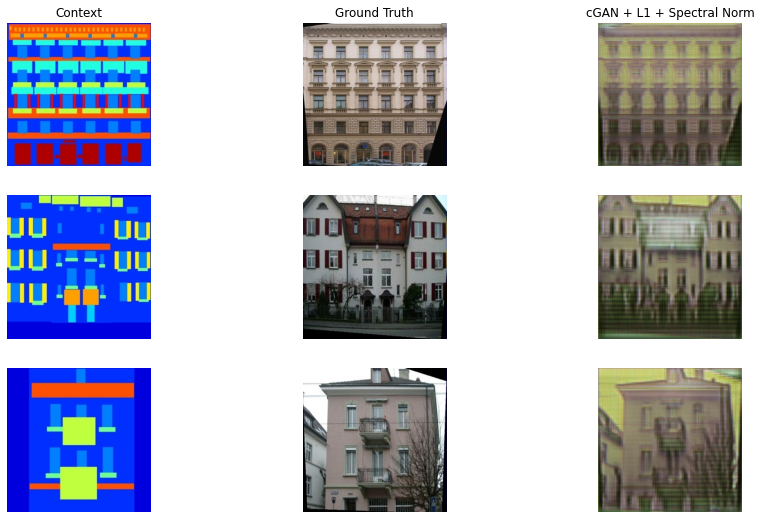

In [ ]:
# Visualization
# Please read Figure 4 in the pix2pix paper first
##########--WRITE YOUR CODE HERE--##########
netGSN.to(device).eval()
real_images=torch.stack((test[8][0], test[20][0], test[32][0])).float().cuda()
contexts = torch.stack((test[8][1], test[20][1], test[32][1])).float().cuda()
gen_gs = netGSN(real_images)

fig, axs = plt.subplots(3, 3, figsize=(15,9))
for i in range(len(real_images)):
  real = cv2.cvtColor(np.float32(np.transpose(real_images[i].cpu().detach().numpy(), [1,2,0]) * 0.5 + 0.5), cv2.COLOR_BGR2RGB)
  context = cv2.cvtColor(np.float32(np.transpose(contexts[i].cpu().detach().numpy(), [1,2,0]) * 0.5 + 0.5), cv2.COLOR_BGR2RGB)
  gen_g = cv2.cvtColor(np.float32(np.transpose(gen_gs[i].cpu().detach().numpy(), [1,2,0]) * 0.5 + 0.5), cv2.COLOR_BGR2RGB)
  axs[i, 0].imshow(context)
  axs[i, 0].axis('off')
  axs[i, 1].imshow(real)
  axs[i, 1].axis('off')
  axs[i, 2].imshow(gen_g)
  axs[i, 2].axis('off')
axs[0, 0].set_title("Context")
axs[0, 1].set_title("Ground Truth")
axs[0, 2].set_title("cGAN + L1 + Spectral Norm")

##########-------END OF CODE-------##########

In [ ]:
# Inception Scores
from torchvision.models.inception import inception_v3
from scipy.stats import entropy

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
inception_model.eval();
up = nn.Upsample(size=(299, 299), mode='bilinear', align_corners=True).type(dtype)
def inception_score(images, splits=10):
    # preds = np.zeros((len(images), 1000))
    ##########--WRITE YOUR CODE HERE--##########
    batch_size=int(len(images) / splits)
    dataloader = torch.utils.data.DataLoader(images, batch_size=batch_size)
    split_scores = []
    scores = []
    for i, batch in enumerate(dataloader):
      batch = Variable(batch.type(dtype))
      x = inception_model(batch)
      x = F.softmax(x).data.cpu().numpy()
      # preds[i*batch_size:i*batch_size + batch_size_i] = x
      py = np.mean(x, axis=0)
      for i in range(x.shape[0]):
        pyx = x[i, :]
        scores.append(entropy(pyx, py))
      split_scores.append(np.exp(np.mean(scores)))

    ##########-------END OF CODE-------##########
    return np.mean(split_scores)


# Get the translation on test set
##########--WRITE YOUR CODE HERE--##########
real_images = []
for i in range(len(test)):
  real_images.append(test[i][0].unsqueeze(0))
real_images = torch.cat(real_images, 0).float().cuda()
test_pred = list(netGSN(real_images))
# test_pred_l1 = list(netGL1SN(real_images))
##########-------END OF CODE-------##########

inception_s = inception_score(test_pred)
# inception_s_l1 = inception_score(test_pred_l1)
print("IS for different losses, evaluated on facades dataset")
from IPython.display import HTML, display
import tabulate
table = [["Loss","IS ↑"],
        #  ["L1", f"{inception_s_l1:.4f}"],
         ["L1 + cGAN", f"{inception_s:.4f}"]]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers="firstrow")))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


IS for different losses, evaluated on facades dataset


Loss,IS ↑
L1 + cGAN,2.9069


GAN with **Spectral Norm** got better Inception Discriminabilty score of **2.9069** compared to GAN with **Batch Norm**; **2.4** and Generator with just L1 loss **1.6**

## Submission guidelines
---
Your need to submit a single zip file to Blackboard described as follow.

Please generate a pdf file that includes a ***google shared link*** (explained in the next paragraph). This pdf file should be named as ***Surname_Givenname_SBUID_hw*\*.pdf** (example: Jordan_Michael_111234567_hw5.pdf for this assignment).

To generate the ***google shared link***, first create a folder named ***Surname_Givenname_SBUID_hw**** in your Google Drive with your Stony Brook account. The structure of the files in the folder should be exactly the same as the one you downloaded. For instance in this homework:

```
Surname_Givenname_SBUID_hw5
        |---facades/
        |---pix2pix.pth
        |---pix2pixL1.pth
        |---CSE527-HW5-fall20.ipynb
        |---download_dataset.sh
```
Note that this folder should be in your Google Drive with your Stony Brook account.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter the TA's email: ***xiang.li.7@stonybrook.edu***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **UNCHECK** the **Notify people** box.

Note that in google colab, we will only grade the version of the code right before the timestamp of the submission made in blackboard. 

To submit to Blackboard, zip ***Surname_Givenname_SBUID_hw*\*.pdf** and ***Surname_Givenname_SBUID_hw**** folder together and name your zip file as ***Surname_Givenname_SBUID_hw*\*.zip**. 

The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw5' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs.


-- DO NOT change the folder structure, please just fill in the blanks. <br>

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be delays in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penalty will be imposed if not using the grace period.
